In [1]:
import matplotlib.pyplot as plt

import numpy as np
from tqdm.notebook import tqdm

from mcopt.pipeline import Pipeline
from mcopt import MorseGraph, ot

In [2]:
pipeline = Pipeline('../pipeline.config.json')

red_sea = pipeline.graph('red_sea')

> Loading red_sea complex
  config unchanged, reading complex


> Loading red_sea graph


In [3]:
cmap = 'cool'

hist = "degree"
dist = "geo"

random_state = 42
rng = np.random.default_rng(random_state)

ms = [0.9 + 0.02 * i for i in range(0, 6)]
ms

[0.9, 0.92, 0.9400000000000001, 0.96, 0.98, 1.0]

In [4]:
graphs = red_sea.frames

src_graph = graphs[0]
dest_graphs = graphs[1:]

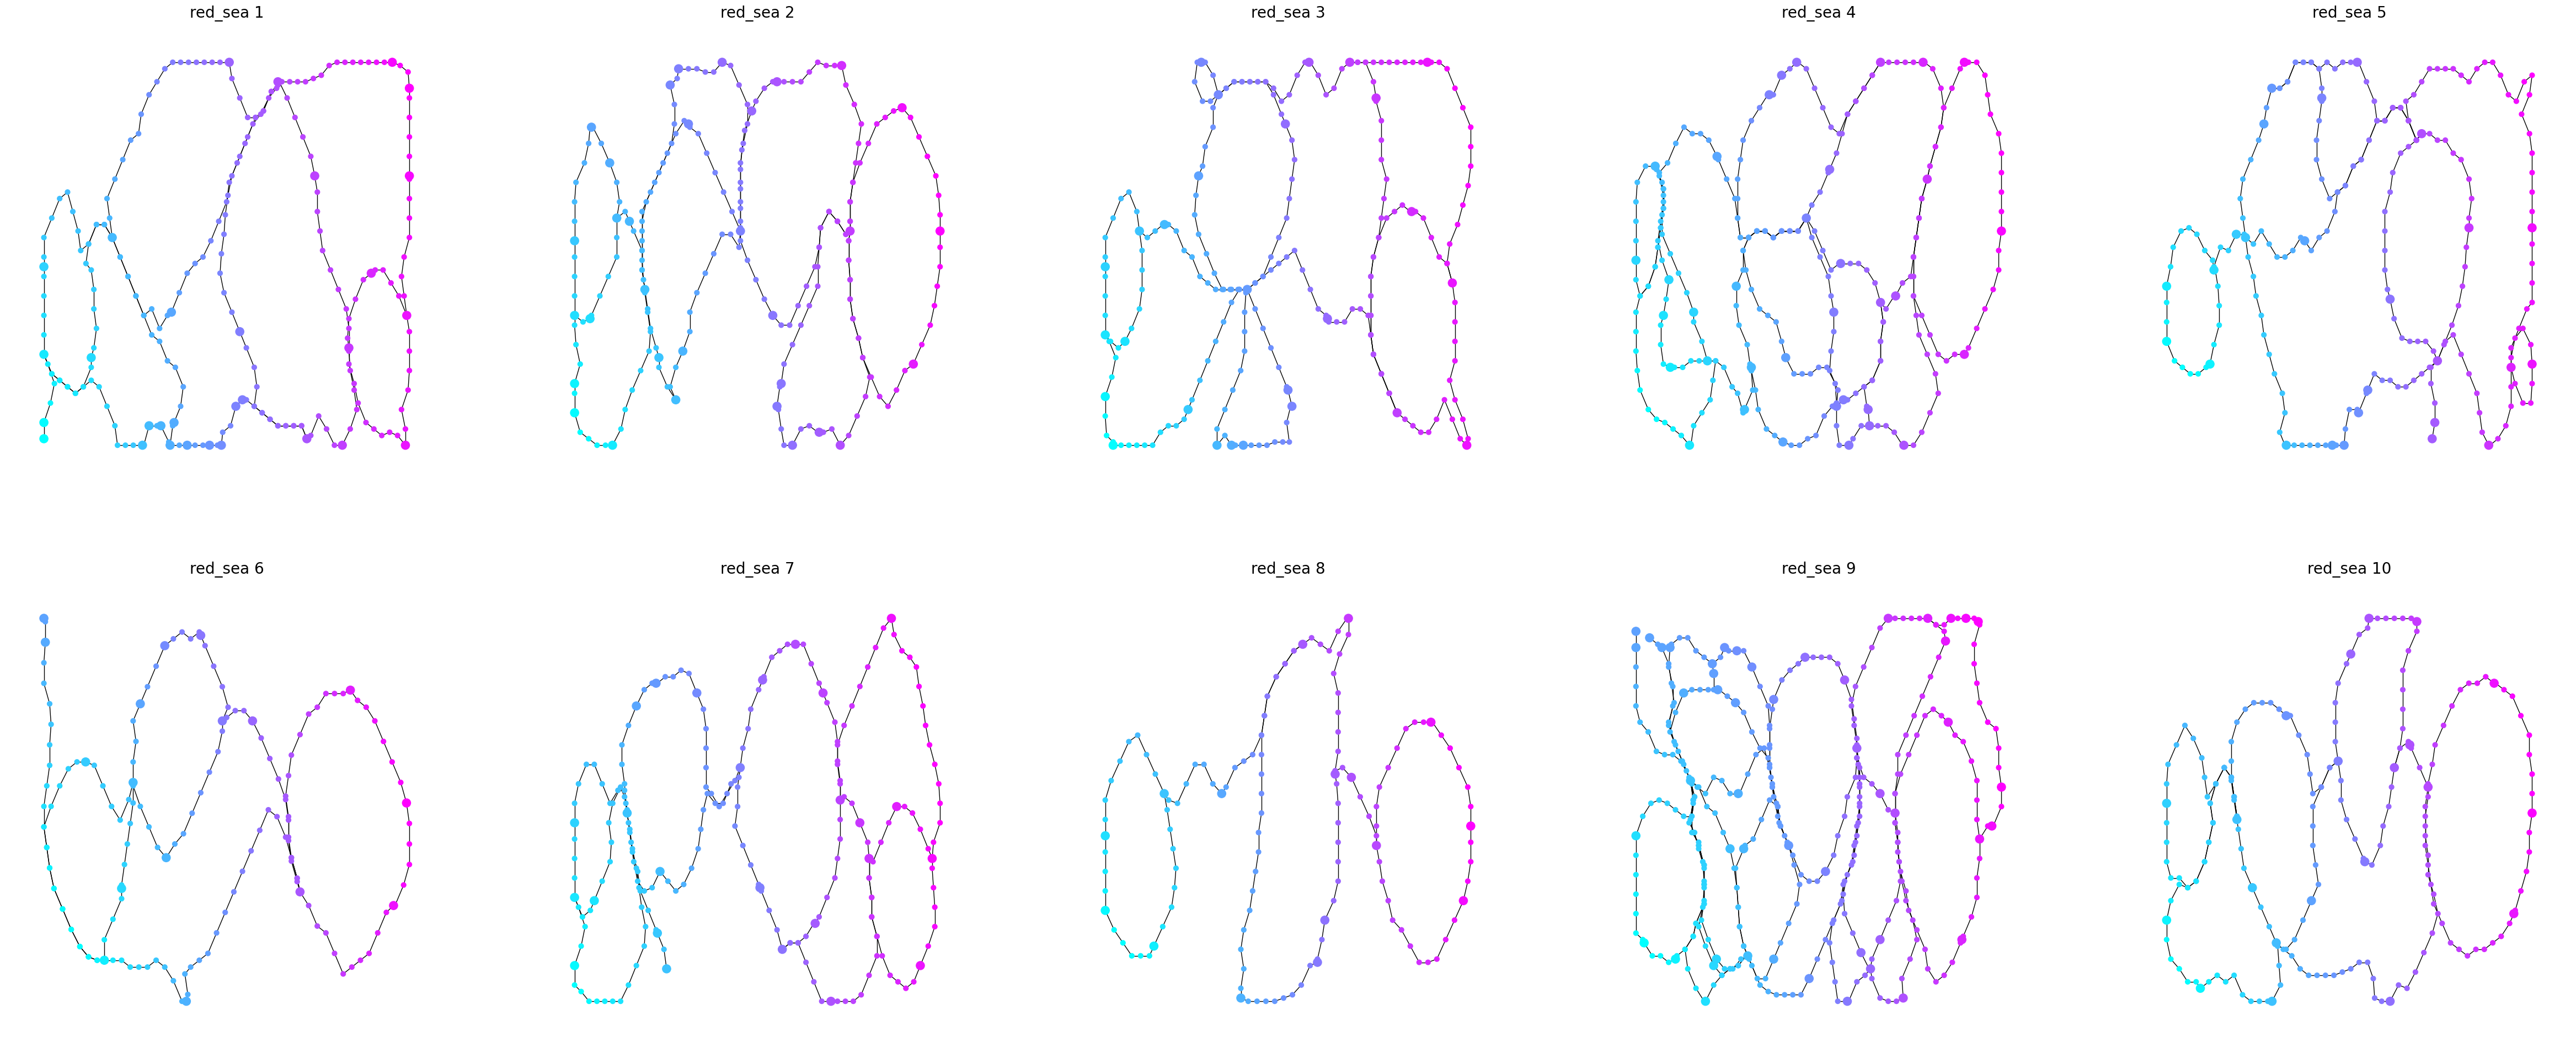

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(60, 24))

for i, (graph, ax) in enumerate(zip(graphs, axes.ravel())):
  graph.draw(ax=ax, cmap=cmap)
  ax.set_title(f'red_sea {i + 1}', fontsize=20)

In [6]:
results = np.zeros(shape = (len(ms), len(dest_graphs)))

In [7]:
src_net = src_graph.to_mpn(hist=hist, dist=dist)

for dest_i, dest_graph in enumerate(tqdm(dest_graphs, desc='Running fpGW for each graph', leave=False)):
    M = MorseGraph.attribute_cost_matrix(src_graph, dest_graph)
    
    dest_net = dest_graph.to_mpn(hist=hist, dist=dist)
    
    for m_i, m in enumerate(tqdm(ms, desc='Running for each m', leave=False)):
      if np.isclose(m, 1):
        coupling, _ = ot.fGW(src_net, dest_net, M)
      else:
        coupling, _ = ot.fpGW(src_net, dest_net, m, M)
          
      max_match_dist = float('-inf')
      
      for dest_n in dest_graph.nodes:
        i = coupling.dest_rev_map[dest_n]
        src_i = coupling[:, i].argmax()
        
        if np.isclose(coupling[src_i, i], 0):
          continue
        
        src_n = coupling.src_map[src_i]
        dest_pos = dest_graph.nodes(data='pos2')[dest_n]
        src_pos = src_graph.nodes(data='pos2')[src_n]
        
        match_dist = np.linalg.norm(dest_pos - src_pos)
        
        if match_dist > max_match_dist:
          max_match_dist = match_dist
      
      results[m_i, dest_i] = max_match_dist

Running fpGW for each graph:   0%|          | 0/9 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

Running for each m:   0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
results.max(axis=0)

array([45.17742799, 32.7184963 , 50.50990002, 66.97947447, 62.15504807,
       39.70201506, 40.92065493, 60.03540622, 59.68458763])

Text(0.5, 0.98, 'Red Sea m tuning')

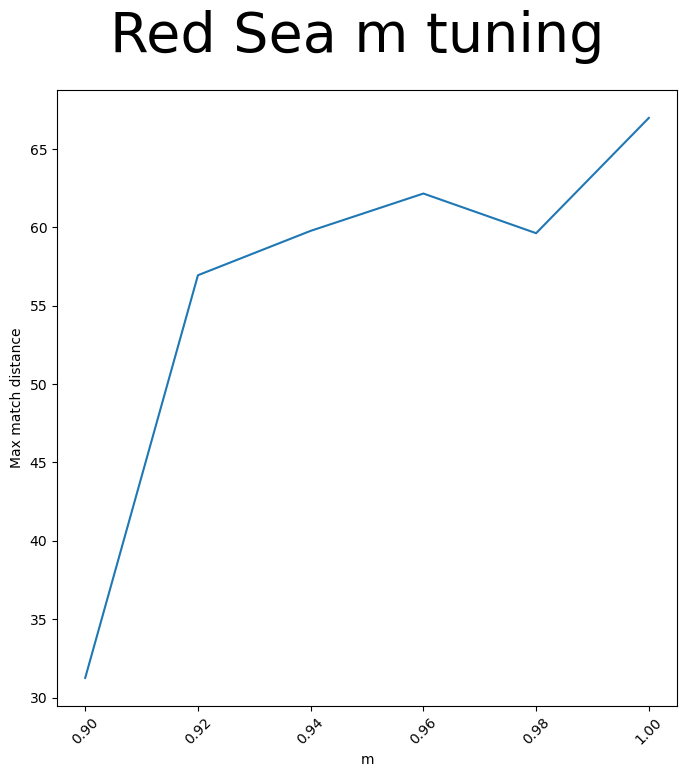

In [11]:
fig_summary, ax_summary = plt.subplots()

x = ms
y = results.max(axis=1)

ax_summary.plot(x, y)
ax_summary.set_xticks(np.round(ms, decimals=2))
ax_summary.tick_params(axis='x', labelrotation=45, labelright=True)

ax_summary.set_xlabel('m')
ax_summary.set_ylabel('Max match distance')

fig_summary.suptitle("Red Sea m tuning", fontsize=40)

Text(0.5, 0.98, 'Red Sea m Tuning')

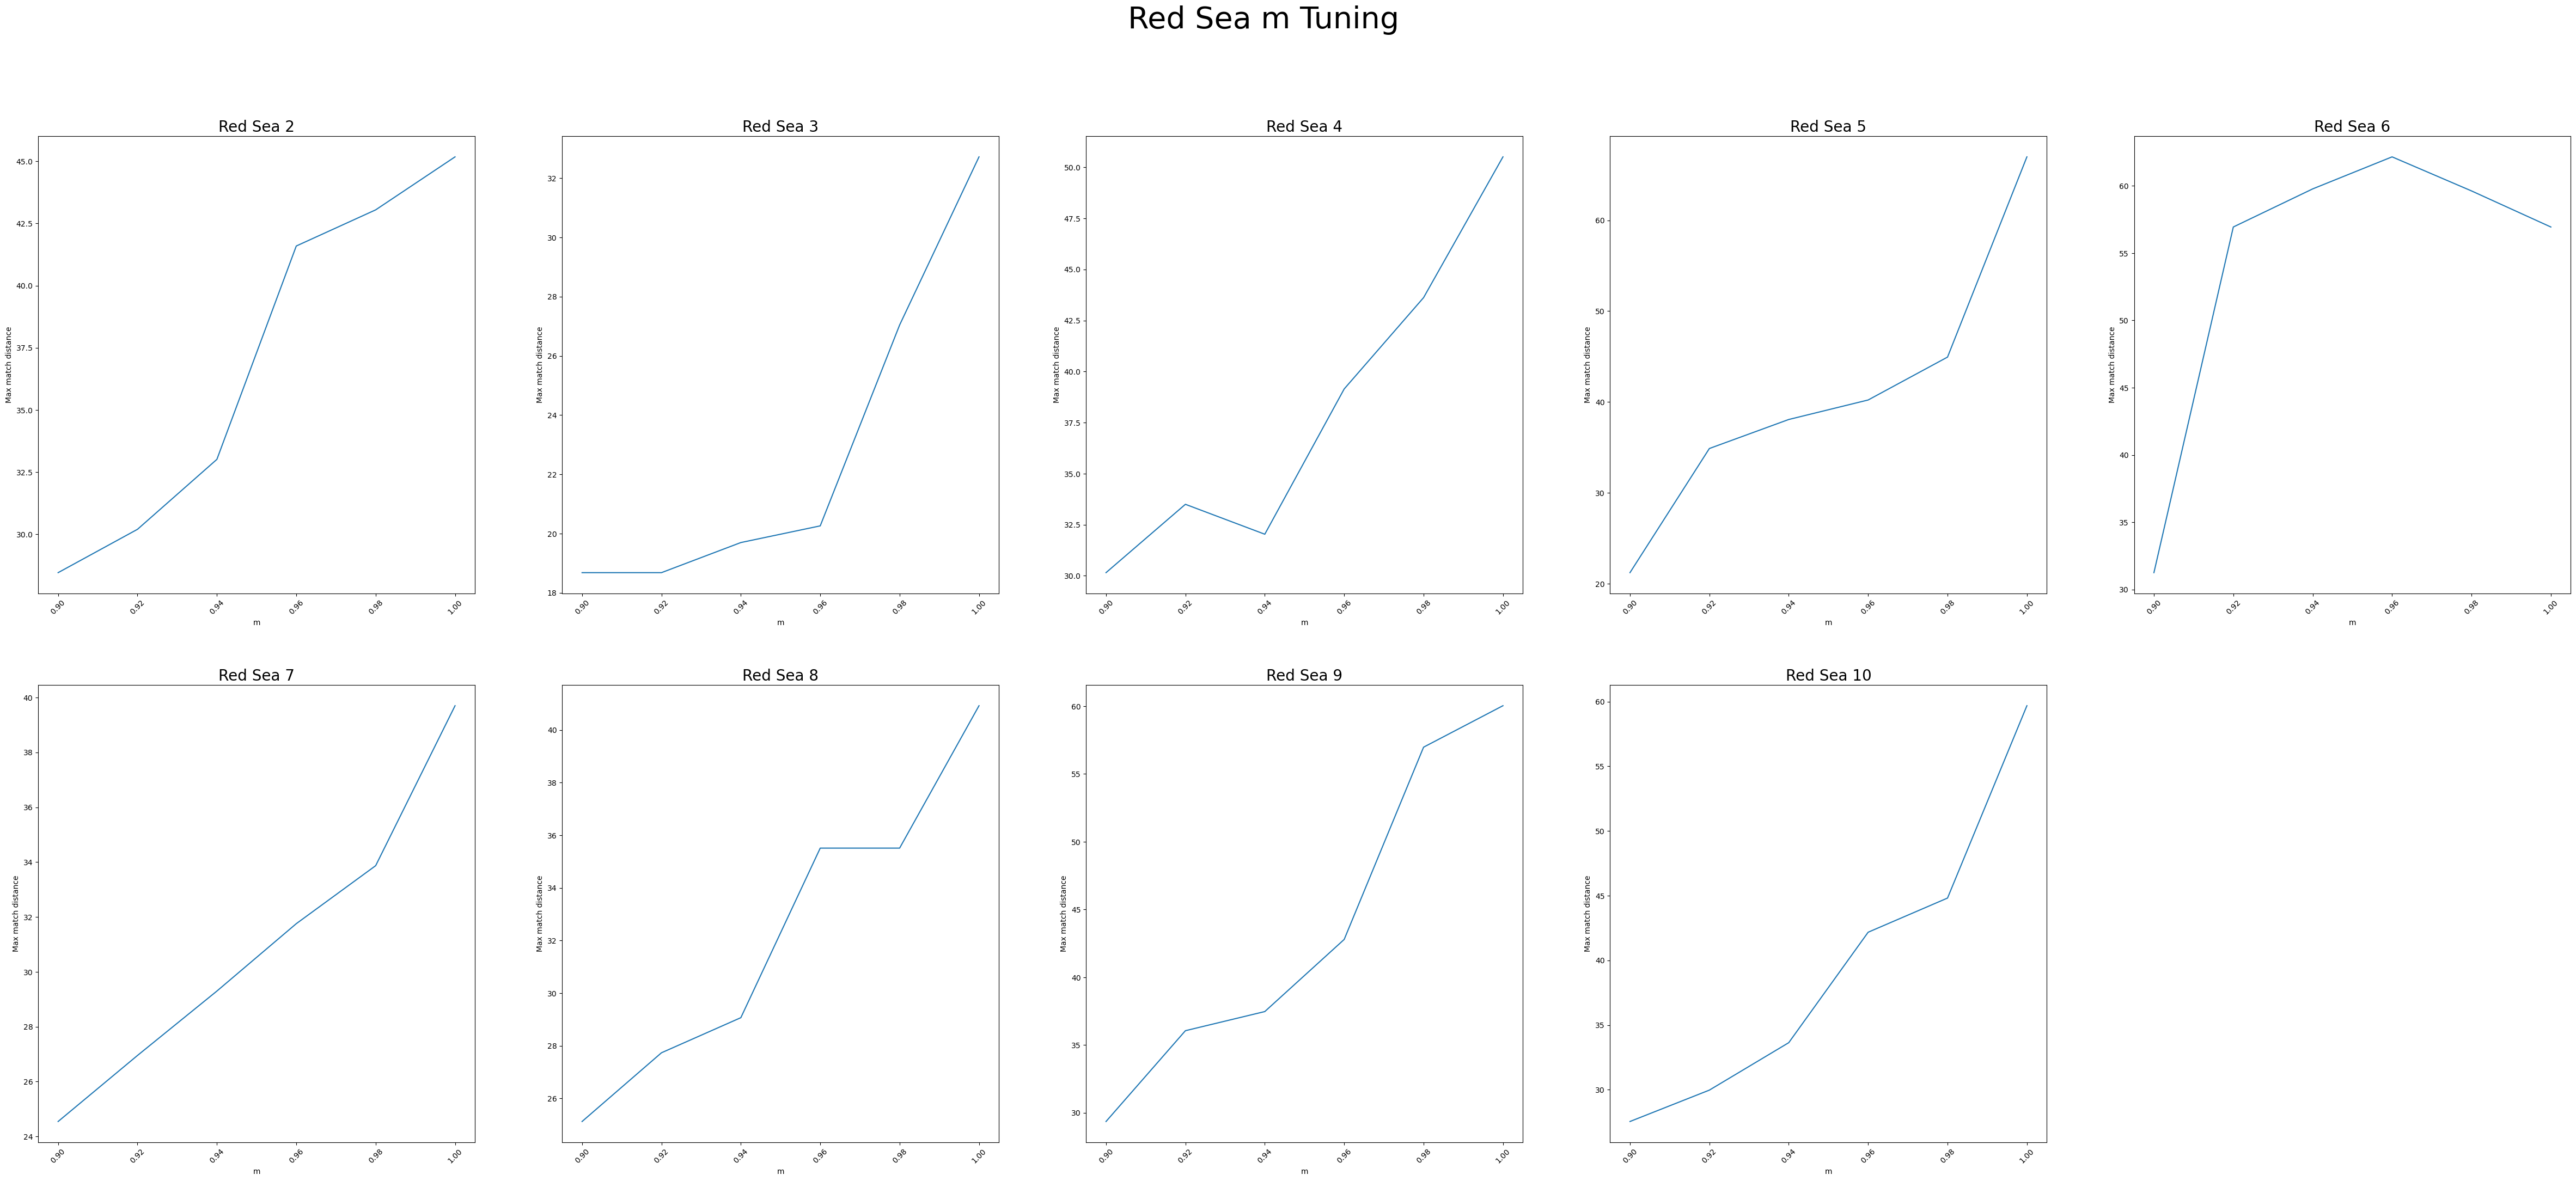

In [14]:
w, h = 5, 2

assert (w * h >= len(dest_graphs))
fig, axes = plt.subplots(h, w, figsize=(w * 12, h * 12))

for dest_i, ax in zip(range(len(dest_graphs)), axes.ravel()):
  x = ms
  y = results[:, dest_i]
  
  ax.plot(x, y)
  ax.set_xticks(np.round(ms, decimals=2))
  ax.tick_params(axis='x', labelrotation=45, labelright=True)
  ax.set_xlabel('m')
  ax.set_ylabel('Max match distance')
  ax.set_title(f'Red Sea {dest_i + 2}', fontsize=20)
  
if len(dest_graph) > len(axes.ravel()):
  for ax in axes.ravel()[len(dest_graphs):]:
    ax.set_axis_off()
    
fig.suptitle("Red Sea m Tuning", fontsize=40)